In [ ]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
###################### lightGBM Hyperopt HPO GPU ###############################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM


In [ ]:
# Clone lightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM

! mkdir build

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [ ]:
# Compile
! cmake -DUSE_GPU=1 #avoid ..
! make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM
Consolidate compiler generated dependencies of target lightgbm_capi_objs
Consolidate compiler generated dependencies of target lightgbm_objs
[ -1%] Built target lightgbm_capi_objs
[ 88%] Built target lightgbm_objs
Consolidate compiler generated dependencies of target lightgbm
[ 90%] Built target _lightgbm
[ 96%] Built target lightgbm


In [ ]:
! sudo apt-get -y install python-pip

! sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna datetime plotly matplotlib==3.4.2 seaborn eli5 shap scikit-learn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/python-package

! sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.txt -> build/lib/lightgbm
running install_lib
copying build/lib/lightgbm/VERSION.txt -> /usr/lib/python3.7/site-packages/lightgbm
INFO:LightGBM:Installing lib_lightgbm from: ['/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/l

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
import csv
from timeit import default_timer as timer
import ast
from datetime import datetime, timedelta
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
import shap 

my_dpi=96

!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed May 25 15:01:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |            

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Set seed 
seed_value = 42
os.environ['UsedCarsCarGurus_lightGBMGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

In [ ]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [ ]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_PKL


In [ ]:
################################################################################
######################    lightGBM HPO GPU    ##################################
######################       300 trials       ##################################
################################################################################
# Define the number of trials
NUM_EVAL = 300

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

# Define parameter grid
lgb_tune_kwargs = {
    'random_state': seed_value,
    'device_type': 'gpu',
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity' : -1,
    'force_col_wise': hp.choice('force_col_wise', "+"),
    'n_estimators': hp.choice('n_estimators', np.arange(400, 700, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': hp.choice('max_depth', np.arange(5, 12, dtype=int)),
    'num_leaves': hp.choice('num_leaves', np.arange(70, 150, dtype=int)),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 0.95)}]),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.75, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

# Define a function for optimization of hyperparameters
def lgb_hpo(config):
    '''lightGBM HPO'''
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  

    # Retrieve the subsample if present otherwise set to 1.0
    subsample = config['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    config['boosting_type'] = config['boosting_type']['boosting_type']
    config['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for param_name in ['max_depth', 'num_leaves']:
        config[param_name] = int(config[param_name])
 
    # Define model type
    lgb = LGBMRegressor(
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(lgb, X_train, y_train, 
                              scoring='neg_root_mean_squared_error', 
                              cv=kfolds)
    
    run_time = timer() - start
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}   


# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = '/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/trialOptions/lightGBM_CV_trials_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(lgb_hpo, lgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate= np.random.RandomState(42))
joblib.dump(bayesOpt_trials, 'lightGBM_CV_Hyperopt_300_GPU.pkl')
# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-05-25 06:15:38.742065
100%|██████████| 300/300 [6:46:24<00:00, 81.28s/it, best loss: 2396.705123053008]
Start Time           2022-05-25 06:15:38.742065
End Time             2022-05-25 13:02:03.360201
6:46:24


In [ ]:
# Sort the trials with lowest loss first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key = lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 2396.705123053008, 'params': {'boosting_type': 'gbdt', 'colsample_bytree': 0.990710247020252, 'device_type': 'gpu', 'force_col_wise': '+', 'learning_rate': 0.1532468845606874, 'max_depth': 11, 'metric': 'rmse', 'n_estimators': 664, 'num_leaves': 149, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.21368623311905155, 'reg_lambda': 0.6081935133906204, 'verbosity': -1, 'subsample': 0.7521090621184197}, 'iteration': 160, 'train_time': 110.59749732300043, 'status': 'ok'}, {'loss': 2397.3821386755544, 'params': {'boosting_type': 'gbdt', 'colsample_bytree': 0.9990197319105564, 'device_type': 'gpu', 'force_col_wise': '+', 'learning_rate': 0.13443271095173615, 'max_depth': 11, 'metric': 'rmse', 'n_estimators': 650, 'num_leaves': 143, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.13676177893122635, 'reg_lambda': 0.6783165993977724, 'verbosity': -1, 'subsample': 0.6583372823931356}, 'iteration': 158, 'train_

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('lightGBM_CV_trials_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

results.to_csv('lightGBM_CV_trials_300_GPU.csv', index=False)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/bayesParams/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_lightGBM_HPO_300_GPU_CV.csv', 
                    index = False)

In [ ]:
# Convert data types for graphing
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['num_leaves'] = bayes_params['num_leaves'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

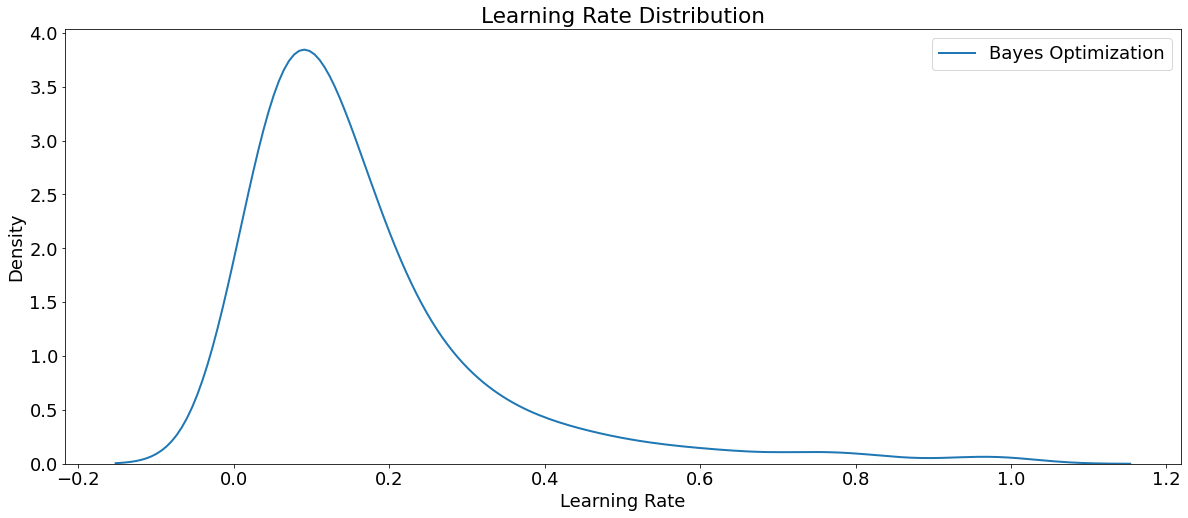

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

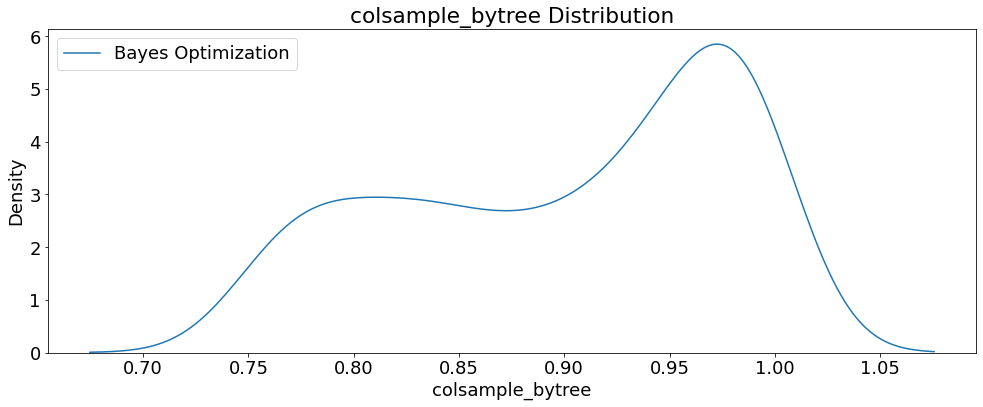

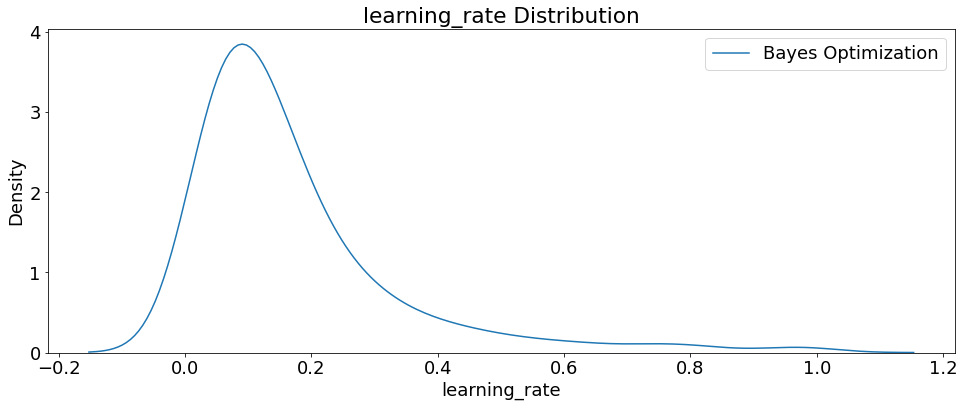

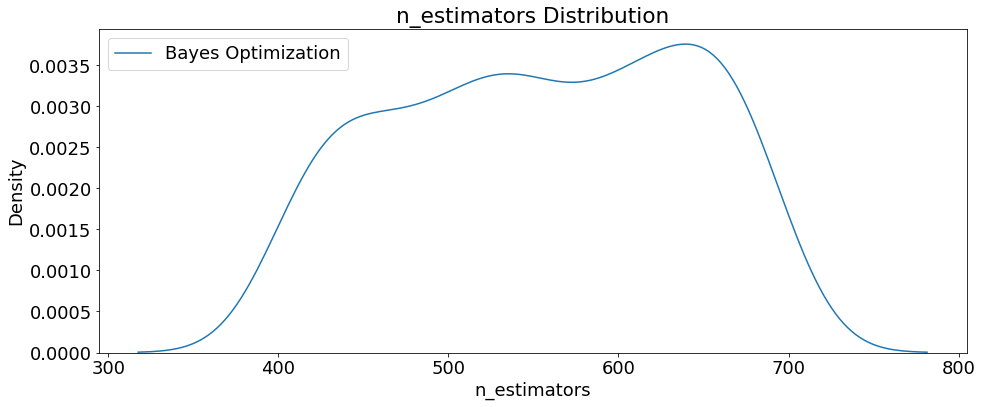

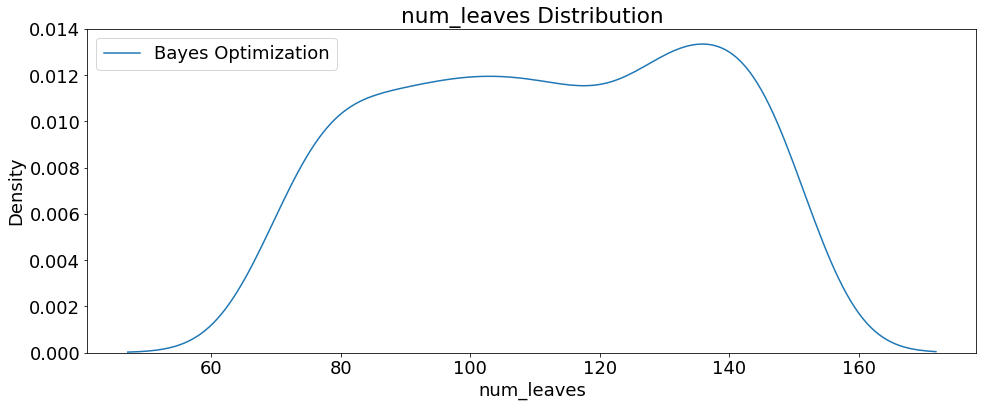

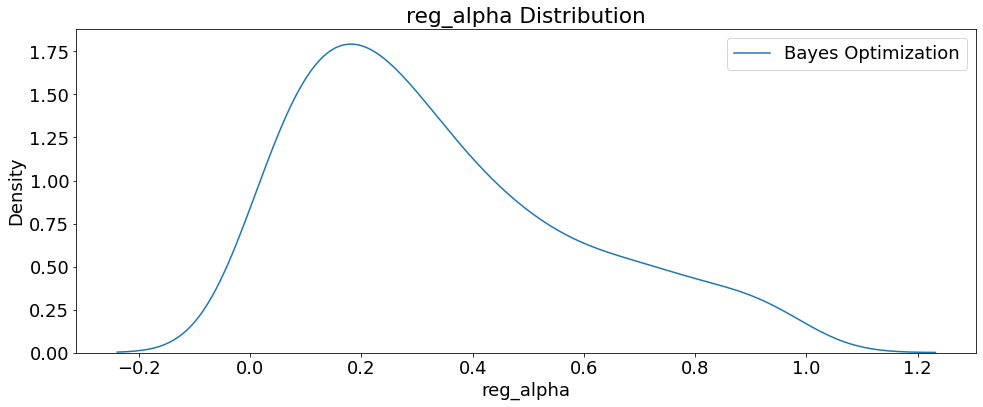

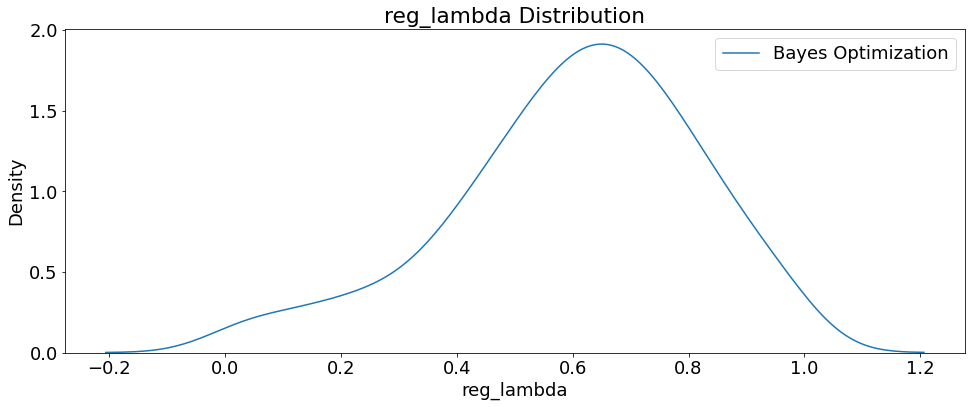

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['boosting_type', 'iteration', 'subsample', 'force_col_wise',
                    'max_depth', 'device_type', 'verbosity', 'random_state',
                    'objective', 'metric']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


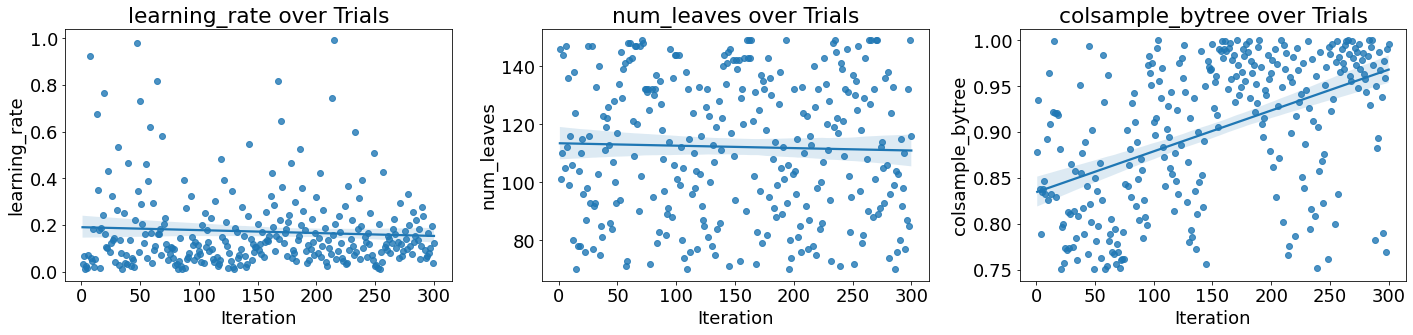

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


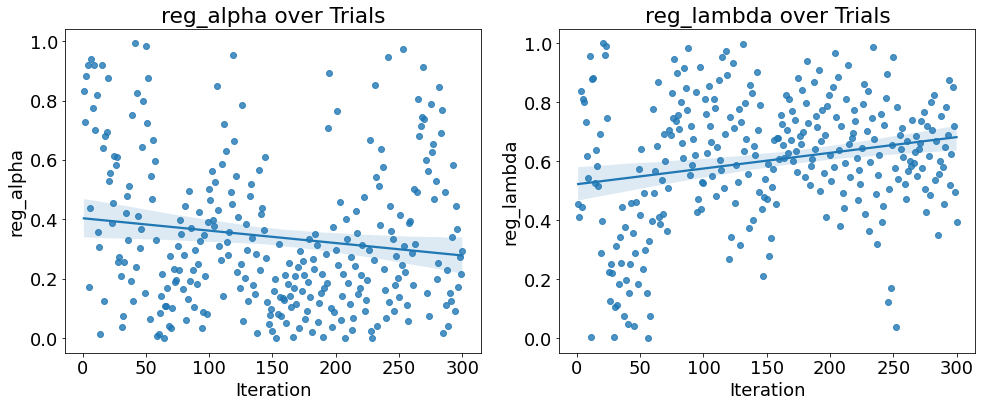

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMRegressor(n_jobs = -1, **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_CV_HPO_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_CV_HPO_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
# Model Metrics
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('\nModel Metrics for lightGBM HPO Hyperopt 300 trials')
print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for lightGBM HPO Hyperopt 300 trials
MAE train: 1341.534, test: 1735.201
MSE train: 3295813.869, test: 5595563.594
RMSE train: 1815.438, test: 2365.494
R^2 train: 0.964, test: 0.939


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5595563.59354 MSE on the test set.
This was achieved after 160 search iterations


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

X2_test = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_Explanations/best_bayes_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_Explanations/best_bayes_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.5332 ± 0.0048,horsepower
0.1328 ± 0.0030,year
0.0732 ± 0.0012,mileage
0.0708 ± 0.0011,width
0.0564 ± 0.0003,height
0.0403 ± 0.0005,wheel_system_display_Front-Wheel Drive
0.0379 ± 0.0009,horsepower_rpm
0.0369 ± 0.0005,fuel_tank_volume
0.0348 ± 0.0006,length
0.0330 ± 0.0009,highway_fuel_economy


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/Model_Explanations


In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

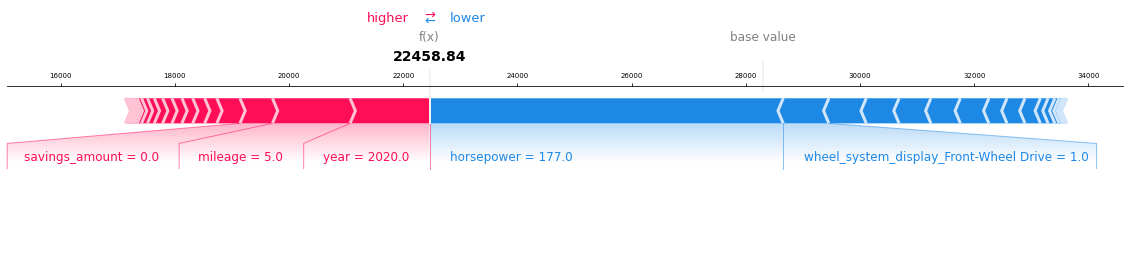

In [ ]:
# Visualize the first prediction's explanation
#fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('lightGBM_HPO_Hyperopt_300_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

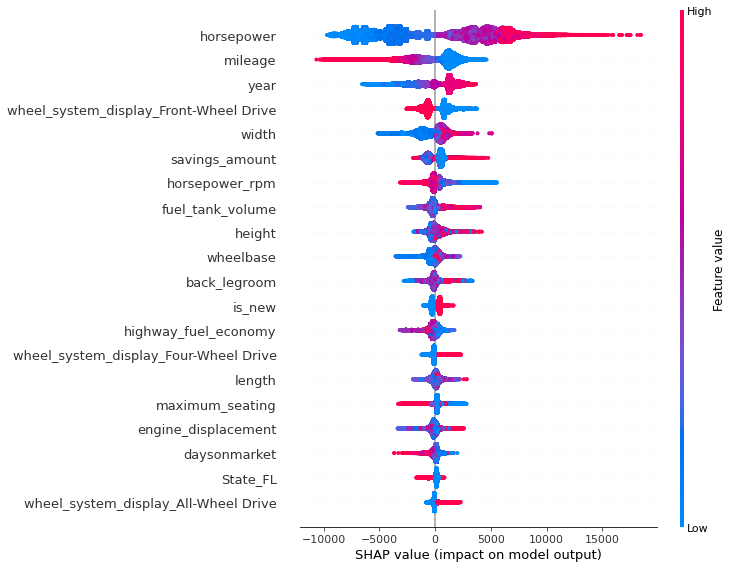

In [ ]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('lightGBM_HPO_Hyperopt_300_GPU_ShapSummary_TrainSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(X_test)

<Figure size 432x288 with 0 Axes>

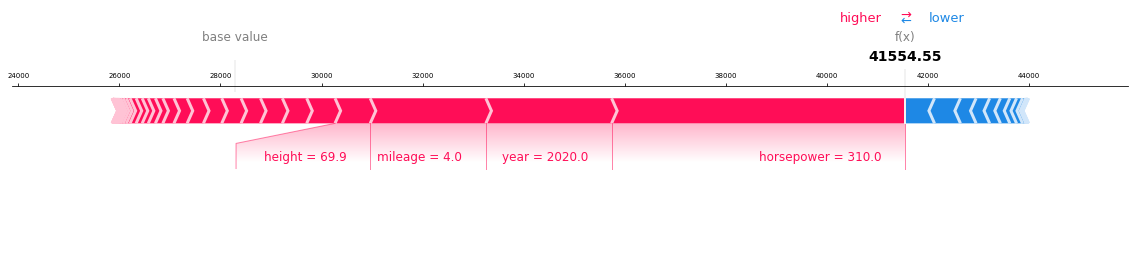

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('lightGBM_HPO_Hyperopt_300_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

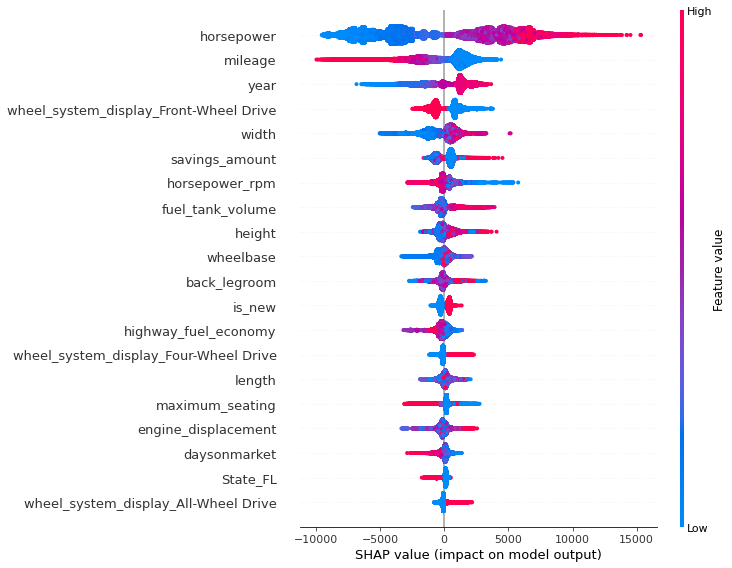

In [ ]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('lightGBM_HPO_Hyperopt_300_GPU_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/bestBayes_WeightsExplain/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Hyperopt/bestBayes_WeightsExplain


In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_300_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')

exp

,feature,weight,std
0,horsepower,0.533249,0.002383
1,year,0.132819,0.001479
2,mileage,0.073229,0.000607
3,width,0.070825,0.000543
4,height,0.056370,0.000156
5,wheel_system_display_Front-Wheel Drive,0.040348,0.000272
6,horsepower_rpm,0.037852,0.000457
7,fuel_tank_volume,0.036877,0.000265
8,length,0.034843,0.000321
9,highway_fuel_economy,0.033026,0.000463
